# Chapter 4. Classifying Surnames with a Multilayer Perceptron

In [1]:
'''
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
use to prevent kernal crash due to re-initializing  libiomp5md.dll
'''
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

'\nimport os\nos.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"\nuse to prevent kernal crash due to re-initializing  libiomp5md.dll\n'

## Imports

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {''@'':0, 'a':1, 'b':2, ....., 'Á': 76}
                                                  # _idx_to_token: {0:''@'', 1:'a', 2:'b', ....., 76:'Á'}
            
                                                  # _token_to_idx: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}
                                                  # _idx_to_token: {0:'Arabic',  1:'Chinese', ...,  17:'Vietnamese'}
  
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
               
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [4]:
from enum import Enum
class Vectorizer_Type(Enum):
    One_Hot = "one-hot"
    Term_Freq = "term-freq"
    TF_IDF = "tf-idf"

from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, vectorizer_type, tfidf_vectorizer=None):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab             # _token_to_idx: {'@':0, 'a':1, 'b':2, ....., 'Á': 76}
        self.nationality_vocab = nationality_vocab     # _token_to_idx: {'Arabic': 0, 'Chinese': 1, ..., 'Vietnamese': 17}

        self.vectorize_type = vectorizer_type
        self.tfidf_vectorizer = tfidf_vectorizer

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname

        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding 
        """
        vocab = self.surname_vocab

        if self.vectorize_type == Vectorizer_Type.TF_IDF: 
            char_vector = self.tfidf_vectorizer.transform([surname]).toarray().flatten()
        elif self.vectorize_type == Vectorizer_Type.Term_Freq:
            char_vector = np.zeros(len(vocab), dtype=np.float32)
            for token in surname:
                char_vector[vocab.lookup_token(token)] += 1
        else :
            char_vector = np.zeros(len(vocab), dtype=np.float32)
            for token in surname:
                char_vector[vocab.lookup_token(token)] = 1  # e.g., kim -> [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ......, 0]

        return char_vector

    @classmethod
    def from_dataframe(cls, surname_df, case_folding, vectorizer_type, ngram_option=None): #ngram_options = [(1,1), (1,2), (2,2), (2,3), (3,3), (3,4)]
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        if case_folding:
            surname_df = surname_df.copy()
            surname_df['surname'] = surname_df['surname'].apply(lambda x: x.lower())

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)   # token is letter-level.
            nationality_vocab.add_token(row.nationality)

        if vectorizer_type == Vectorizer_Type.TF_IDF :
            tfidf_vectorizer = TfidfVectorizer(analyzer='char', token_pattern=None, ngram_range=ngram_option)  # support unigram + bigram words
            tfidf_vectorizer.fit(surname_df.surname)
        else :
            tfidf_vectorizer = None

        return cls(surname_vocab, nationality_vocab, vectorizer_type, tfidf_vectorizer)

### The Dataset

In [6]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights for handling unbalanced data
        class_counts = surname_df.nationality.value_counts().to_dict() # {'English': 2972, 'Russian': 2373, ....}
        
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0]) # e.g, index of English is 4
        sorted_counts = sorted(class_counts.items(), key=sort_key)   # sort by the index number of nationality_vocab
                                # {('Arabic', 1603), ('Chinese', 220), ('Czech', 414), ('Dutch', 236),('English', 2972), ...}

        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32) 
                                                                     # [1/1603, 1/220, 1/414, 1/236, 1/2972, ...]
                                                                     # E.g., penalty for Chinese is higher than one for Arabic.
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv, case_folding, vectorizer_type, ngram_option):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df, case_folding, vectorizer_type, ngram_option))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)   # e.g., 'kim' -> [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ......, 0]

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)  # e.g., 'Korean' -> 11

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader: # {'x_surname': [[1,1,..,0,1], [0,0,...,1,0], ...], 
                                 #  'y_nationality': [4, 5, 10, ..., 14, 4]}
        out_data_dict = {}
        for name, tensor in data_dict.items():  # name: x_surname & y_nationality
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict  # return out_data_dict whenever this generator function is called

## The Model: SurnameClassifier

In [7]:
class SurnameClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim, enable_second_hidden_layer, enable_batch_norm, dropout_rate=0):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.dropout_rate = dropout_rate
        self.enable_second_hidden_layer = enable_second_hidden_layer
        self.enable_batch_norm = enable_batch_norm

        self.fc1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        if enable_batch_norm:
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        if self.dropout_rate != 0 :
            self.dropout1 = nn.Dropout(p=self.dropout_rate)

        if enable_second_hidden_layer :
            self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2) ###base on experience from lab assignment 1
            if enable_batch_norm:
                self.batch_norm2 = nn.BatchNorm1d(hidden_dim // 2)
            if self.dropout_rate != 0 :    
                self.dropout2 = nn.Dropout(p=self.dropout_rate)
            self.fc_final = nn.Linear(hidden_dim // 2, out_features=output_dim)
        else :
            self.fc_final = nn.Linear(hidden_dim, out_features=output_dim)

        #original enable_batch_norm = true, dropout_rate=0.2, 1 hidden layer
        # self.fc2 = nn.Linear(hidden_dim, output_dim)
        # self.bn1 = nn.BatchNorm1d(hidden_dim) # for batch norm, need to be defined for each layer
        # self.dpout = nn.Dropout(p=0.2) # for drop out, p = probability of an element to be zeroed. Default: 0.5


    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        # x_in = x_in.float()
        intermediate = self.fc1(x_in.float())            # [batch, num_features] -> [batch, hidden_dim]
        if self.enable_batch_norm:
            intermediate = self.batch_norm1(intermediate)  
        intermediate = F.relu(intermediate)      # [batch, hidden_dim]
        if self.dropout_rate != 0 :
            intermediate = self.dropout1(intermediate)

        if self.enable_second_hidden_layer:
            # Second hidden layer
            intermediate = self.fc2(intermediate)
            if self.enable_batch_norm:
                intermediate = self.batch_norm2(intermediate)
            intermediate = F.relu(intermediate)
            if self.dropout_rate != 0 :
                intermediate = self.dropout2(intermediate)

        prediction_vector = self.fc_final(intermediate) 
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
        return prediction_vector

        ### original
        # intermediate_vector = self.fc1(x_in)                         # (batch, input_dim) -> (batch, hidden_dim)
        # intermediate_vector = self.bn1(intermediate_vector)          # batch norm
        # intermediate_vector = F.relu(intermediate_vector)            # activation function
        # intermediate_vector = self.dpout(intermediate_vector)        # dropout
        
        # prediction_vector = self.fc2(intermediate_vector)            # (batch, hidden_dim) -> (batch, output_dim)

        # if apply_softmax:
        #     prediction_vector = F.softmax(prediction_vector, dim=1)  # (batch, output_dim)

        # return prediction_vector                                     # (batch, output_dim)

## Training Routine

### Helper functions

In [8]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # print(train_state['train_acc'])
        if train_state['early_stopping_step'] >= args.early_stopping_criteria or train_state['train_acc'][-1] > 99.9 : ### if  train_state['train_acc'] > 0.999 also can stop directly
            train_state['stop_early'] = True
        else : 
            train_state['stop_early'] = False

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [9]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [10]:
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options
    cuda=False,
    expand_filepaths_to_save_dir=True,
    dropout_rate=0.2, # original value

    ###newly added, now is the default value
    case_folding=False,
    vectorizer_type=Vectorizer_Type.One_Hot,
    ngram_option=(1,2), # only valid when Vectorizer_Type is tf-idf
    enable_second_hidden_layer=False,
    enable_batch_norm=True,
    weight_decay=0, ##change to 0 to disable
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)   
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch4/surname_mlp\model.pth
Using CUDA: False


### Initializations

In [11]:
# create dataset and vectorizer
def init(args) :
    print("Creating fresh!")
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv, args.case_folding , args.vectorizer_type, args.ngram_option)
        
    vectorizer = dataset.get_vectorizer()
    if args.vectorizer_type == Vectorizer_Type.TF_IDF :
        num_features = len(vectorizer.tfidf_vectorizer.vocabulary_)
        print(f'number of features => {num_features}')
        classifier = SurnameClassifier(input_dim=num_features, 
                                hidden_dim=args.hidden_dim, 
                                output_dim=len(vectorizer.nationality_vocab),
                                enable_second_hidden_layer = args.enable_second_hidden_layer,
                                enable_batch_norm = args.enable_batch_norm,
                                dropout_rate=args.dropout_rate
                                )
    else :
        classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                                hidden_dim=args.hidden_dim, 
                                output_dim=len(vectorizer.nationality_vocab),
                                enable_second_hidden_layer = args.enable_second_hidden_layer,
                                enable_batch_norm = args.enable_batch_norm,
                                dropout_rate=args.dropout_rate
                                )
    return dataset, vectorizer, classifier


In [12]:
def printClassifier(classifier) :
        for idx, m in enumerate(classifier.named_modules()):
                print(idx, '->', m)

In [13]:
def printClassifierParameters(classifier) :
    for param in classifier.parameters():
        print(type(param), param.size())

In [14]:
# vectorizer.surname_vocab._token_to_idx

In [15]:
# vectorizer.nationality_vocab._token_to_idx

### Training loop

In [16]:
def train_model(args, dataset, classifier, disable_tqdm=False) : 
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)

        
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)  # add class_weight for an unbalanced dataset
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    #optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=0.001) # weight_decay for L2 regularization
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=10) # update learning rate

    train_state = make_train_state(args)

    epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0, disable=disable_tqdm)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True, disable=disable_tqdm)
    dataset.set_split('val')
    val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True, disable=disable_tqdm)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on

            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = classifier(batch_dict['x_surname'])         # (batch, input_dim) -> (batch, output_dim)

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_nationality'])  # (batch, output_dim), (batch) -> scalar value
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                            batch_size=args.batch_size, 
                                            device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  classifier(batch_dict['x_surname'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_nationality'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                            train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")
    return train_state, loss_func

In [17]:

import matplotlib.pyplot as plt

def draw_loss_and_acc(train_state, title) :
    epochs = range(1, len(train_state['train_acc']) + 1)
    fig, ax1 = plt.subplots(1, 2, figsize=(15, 7))

    fig.suptitle(title, fontsize=16, fontweight="bold")

    ax1[0].plot(epochs, train_state['train_loss'], 'bo-', label='Training Loss')
    ax1[0].plot(epochs, train_state['val_loss'], 'r-', label='Validation Loss') 
    ax1[0].set_title('Training and Validation Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend()

    ax1[1].plot(epochs, train_state['train_acc'], 'go-', label='Training Accuracy')
    ax1[1].plot(epochs, train_state['val_acc'], 'm-', label='Validation Accuracy') 
    ax1[1].set_title('Training and Validation Accuracy')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('Accuracy')
    ax1[1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout() 
    plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# compute the loss & accuracy on the test set using the best available model
def check_test_data(args, dataset, classifier, train_state, loss_func, enable_print_info=True) :
    classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=False)) # load the best model

    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    y_pred_list = []         # store predicted values for confusion matrix
    y_nationality_list = []  # ground truth value

    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_surname'])
        
        # store predicted values and ground truth values for calculating confusion matrix
        # y_pred_list.extend(y_pred.max(dim=1)[1].numpy())
        y_pred_list.extend(y_pred.max(dim=1)[1].cpu().numpy())
        # y_nationality_list.extend(batch_dict['y_nationality'].numpy())
        y_nationality_list.extend(batch_dict['y_nationality'].cpu().numpy())
        
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_nationality'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc

    if enable_print_info: 
        print("==================================dividing line==================================")
        print("Test loss: {};".format(train_state['test_loss']))
        print("Test Accuracy: {}".format(train_state['test_acc']))
        print("==================================dividing line==================================")
        print(confusion_matrix(y_nationality_list, y_pred_list).T)  
    
    if enable_print_info: 
        nationality_classes = []
        for i in range(len(dataset._vectorizer.nationality_vocab)):
            nationality_classes.append(dataset._vectorizer.nationality_vocab.lookup_index(i))
        print(nationality_classes)
    
    if enable_print_info :
        cm = confusion_matrix(y_nationality_list, y_pred_list)
        cm_df = pd.DataFrame(cm.T, index=nationality_classes, columns=nationality_classes)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print(cm_df)

    if enable_print_info :
        print(classification_report(y_nationality_list, y_pred_list))
    
    return train_state['test_acc']

Creating fresh!


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/120 [00:00<?, ?it/s]

split=val:   0%|          | 0/25 [00:00<?, ?it/s]

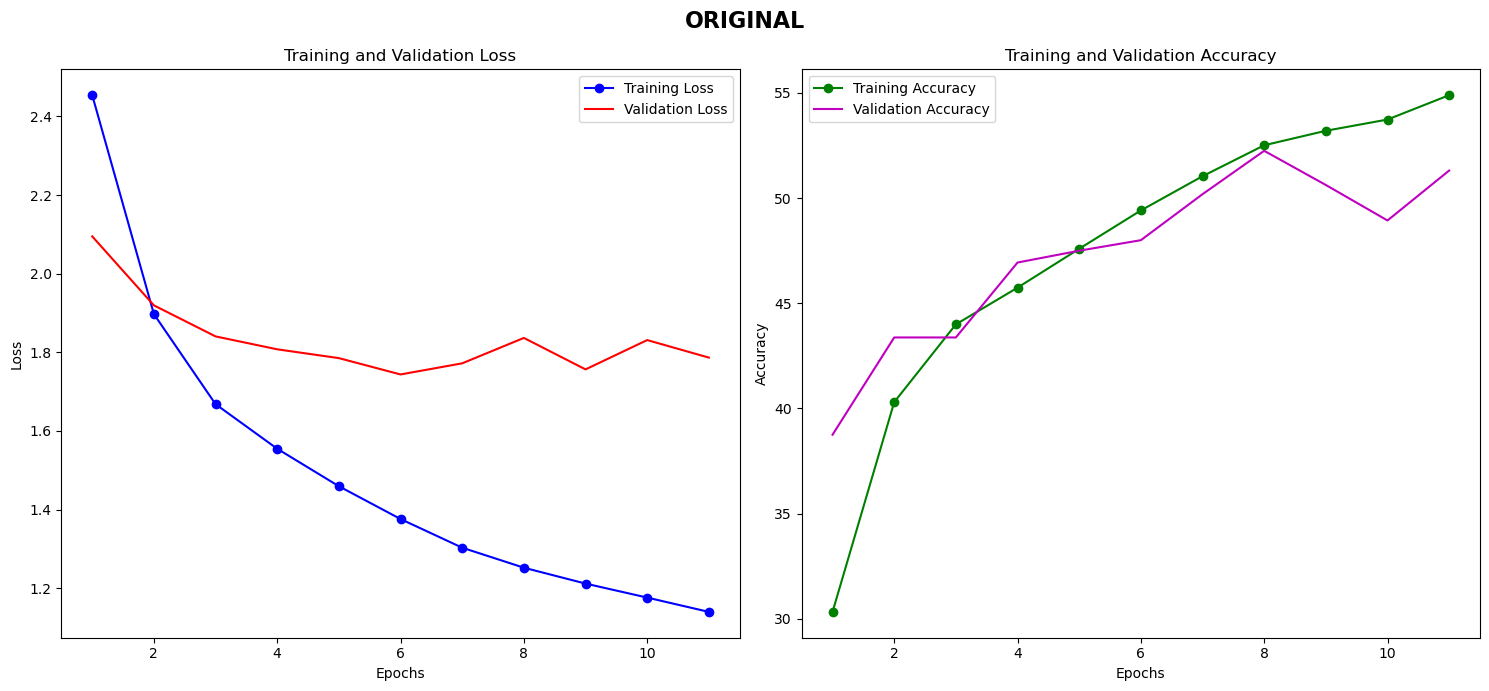

==================================dividing line==================================
Test loss: 1.6678011703491211;
Test Accuracy: 48.5625
==================================dividing line==================================
[[204   0   4   0  20   0   7   0   3   0  19   0   0   0   4   0   1   0]
 [  0  16   0   0   6   2   0   0   2   2   1   2   0   0   4   0   1   2]
 [  0   0  14   0  15   1   2   0   0   0   1   0   2   0   9   0   0   0]
 [  2   0   6  24  45   0  12   0   1   2   2   1   0   0   9   1   0   0]
 [  0   0   5   2  92   2   1   0   1   0   3   0   0   1   4   1   1   0]
 [  0   0   1   0  39  13   3   1   1   4   1   0   0   1   7   0   1   0]
 [  0   1   8   0  25   1  28   0   2   2   1   0   0   0   5   2   0   0]
 [  5   0   2   1  11   0   1   9   0   3   2   0   0   0  14   2   2   0]
 [  4   1   4   2  30   2   0   0   9   6   2   1   0   0   8   0   1   2]
 [  5   1   3   1  27   1   6   0   2  41   2   0   1   0  14   0   7   0]
 [  7   0   0   1  10   0   0   

48.5625

In [19]:
dataset, vectorizer, classifier = init(args)
train_state, loss_func = train_model(args, dataset=dataset, classifier=classifier)
draw_loss_and_acc(train_state, "ORIGINAL")
check_test_data(args, dataset, classifier, train_state, loss_func, enable_print_info=True)

# paramters selection

In [20]:
import optuna
import pandas as pd

vectorizer_type_mapping = {
    "one-hot": Vectorizer_Type.One_Hot,
    "term-freq": Vectorizer_Type.Term_Freq,
    "tf-idf": Vectorizer_Type.TF_IDF
}
ngram_options = ["1,1", "1,2", "1,3", "2,3", "2,4", "3,4"]

def objective(trial):
    vectorizer_type_str = trial.suggest_categorical("vectorizer_type", ["one-hot", "term-freq", "tf-idf"])

    if vectorizer_type_str == "tf-idf": ##only use this parameter when vectorizer_type = tf-idf
        ngram_str = trial.suggest_categorical("ngram_option", ngram_options)
        ngram_option = tuple(map(int, ngram_str.split(',')))
    else:
        ngram_option = None

    args = Namespace(
        surname_csv="data/surnames/surnames_with_splits.csv",
        model_state_file="model.pth",
        save_dir="model_storage/ch4/surname_mlp",
        early_stopping_criteria=3, ##for quicker stop
        num_epochs=100,
        seed=1337,
        catch_keyboard_interrupt=True,
        cuda=True,
        expand_filepaths_to_save_dir=True,
        reload_from_files=False,

        hidden_dim=trial.suggest_categorical("hidden_dim", [100, 200, 300, 400, 500]),
        batch_size=trial.suggest_categorical("batch_size", [64, 128, 256]), ###i think this no need to check
        learning_rate=trial.suggest_categorical("learning_rate", [0.0001, 0.0005, 0.001, 0.01]),
        dropout_rate=trial.suggest_categorical("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5]),
        vectorizer_type=vectorizer_type_mapping[vectorizer_type_str],  ## prevent too much warning
        case_folding=trial.suggest_categorical("case_folding", [True, False]),
        ngram_option=ngram_option,
        enable_second_hidden_layer=trial.suggest_categorical("enable_second_hidden_layer", [True, False]),
        enable_batch_norm=trial.suggest_categorical("enable_batch_norm", [True, False]),
        weight_decay=trial.suggest_categorical("weight_decay", [0, 0.0001, 0.001, 0.01]),
    )

    # if args.expand_filepaths_to_save_dir:
    #     args.model_state_file = os.path.join(args.save_dir,
    #                                         args.model_state_file)    
    #     print("Expanded filepaths: ")
    #     print("\t{}".format(args.model_state_file))
    if not torch.cuda.is_available():
        args.cuda = False
    # print("Using CUDA: {}".format(args.cuda))

    args.device = torch.device("cuda" if args.cuda else "cpu")
    # Set seed for reproducibility
    set_seed_everywhere(args.seed, args.cuda)
    # handle dirs ; creat dirs if they don't exist
    handle_dirs(args.save_dir)

    # Train model
    dataset, vectorizer, classifier = init(args)
    train_state, loss_func = train_model(args, dataset=dataset, classifier=classifier, disable_tqdm=True)
    # Compute accuracy
    test_acc = check_test_data(args, dataset, classifier, train_state, loss_func, enable_print_info=False)
    return test_acc  # Optuna will maximize this value

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler()) ### prevent Local optimal solution
study.optimize(objective, n_trials=100)

df = study.trials_dataframe().sort_values("value", ascending=False).head(10)

# Extract top 10 best trials with all parameters
top_10_trials = df[[    
    "value",  # Test Accuracy
    "params_case_folding",  # preprocesssing
    "params_ngram_option",  #N-gram selection

    # hyper-parameters
    "params_hidden_dim", "params_batch_size", "params_learning_rate",
    "params_dropout_rate", "params_vectorizer_type", 
    "params_enable_second_hidden_layer", "params_enable_batch_norm",
    "params_weight_decay"
]].to_dict(orient="records")

# Print the top 5 best parameter combinations
print("\nTop 10 Best Hyperparameter Combinations:")
for i, trial in enumerate(top_10_trials):
    print(f"\n🔹 **Rank {i+1}:** Accuracy = {trial['value']:.4f}")
    print({key.replace("params_", ""): value for key, value in trial.items() if key != "value"})

[I 2025-02-28 12:28:23,943] A new study created in memory with name: no-name-9ecf9dfc-1c34-4774-80d1-ce35730d4664


Creating fresh!


[I 2025-02-28 12:28:40,339] Trial 0 finished with value: 48.625 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 0 with value: 48.625.


Creating fresh!


[I 2025-02-28 12:29:06,720] Trial 1 finished with value: 41.145833333333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 0 with value: 48.625.


Creating fresh!
number of features => 5386


[I 2025-02-28 12:29:27,790] Trial 2 finished with value: 67.0 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,3', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:30:05,730] Trial 3 finished with value: 39.1875 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:30:28,115] Trial 4 finished with value: 45.49999999999999 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:30:57,887] Trial 5 finished with value: 41.937500000000014 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:31:20,266] Trial 6 finished with value: 43.294270833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 5337


[I 2025-02-28 12:31:47,935] Trial 7 finished with value: 56.5625 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:32:09,581] Trial 8 finished with value: 42.5625 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 5386


[I 2025-02-28 12:32:28,489] Trial 9 finished with value: 65.8203125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,3', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:32:37,631] Trial 10 finished with value: 39.12499999999999 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:32:44,219] Trial 11 finished with value: 32.942708333333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 17152


[I 2025-02-28 12:33:07,167] Trial 12 finished with value: 61.1328125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '3,4', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 721


[I 2025-02-28 12:33:27,659] Trial 13 finished with value: 5.013020833333333 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,2', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:33:42,559] Trial 14 finished with value: 50.91145833333333 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:33:49,283] Trial 15 finished with value: 51.187499999999986 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.001}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:34:46,612] Trial 16 finished with value: 35.872395833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 49


[I 2025-02-28 12:37:19,974] Trial 17 finished with value: 43.125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 49


[I 2025-02-28 12:38:28,370] Trial 18 finished with value: 24.874999999999996 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 721


[I 2025-02-28 12:40:42,756] Trial 19 finished with value: 58.3984375 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,2', 'hidden_dim': 100, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:40:53,662] Trial 20 finished with value: 49.73958333333333 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:41:23,639] Trial 21 finished with value: 36.125 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:41:31,785] Trial 22 finished with value: 50.0 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:41:37,873] Trial 23 finished with value: 48.12500000000001 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 5337


[I 2025-02-28 12:41:56,564] Trial 24 finished with value: 64.0625 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:42:21,316] Trial 25 finished with value: 37.825520833333336 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 5337


[I 2025-02-28 12:42:40,515] Trial 26 finished with value: 1.953125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 400, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 49


[I 2025-02-28 12:43:32,931] Trial 27 finished with value: 38.99739583333333 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 2 with value: 67.0.


Creating fresh!


[I 2025-02-28 12:44:08,309] Trial 28 finished with value: 40.4296875 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 17824


[I 2025-02-28 12:44:31,431] Trial 29 finished with value: 65.69010416666666 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 300, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 2 with value: 67.0.


Creating fresh!
number of features => 721


[I 2025-02-28 12:45:09,035] Trial 30 finished with value: 67.3828125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,2', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 30 with value: 67.3828125.


Creating fresh!


[I 2025-02-28 12:45:19,793] Trial 31 finished with value: 41.49999999999999 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 30 with value: 67.3828125.


Creating fresh!


[I 2025-02-28 12:45:27,232] Trial 32 finished with value: 40.4296875 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 30 with value: 67.3828125.


Creating fresh!


[I 2025-02-28 12:45:33,814] Trial 33 finished with value: 46.940104166666664 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 30 with value: 67.3828125.


Creating fresh!
number of features => 17824


[I 2025-02-28 12:46:41,655] Trial 34 finished with value: 70.703125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:18,440] Trial 35 finished with value: 42.37500000000001 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:22,682] Trial 36 finished with value: 37.434895833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:31,448] Trial 37 finished with value: 40.75520833333333 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:45,491] Trial 38 finished with value: 43.75 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:53,966] Trial 39 finished with value: 47.625 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:47:59,692] Trial 40 finished with value: 37.369791666666664 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17824


[I 2025-02-28 12:48:24,269] Trial 41 finished with value: 65.10416666666666 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:48:46,159] Trial 42 finished with value: 36.458333333333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:48:52,852] Trial 43 finished with value: 45.638020833333336 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:48:58,288] Trial 44 finished with value: 31.25 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:49:06,358] Trial 45 finished with value: 44.921875 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:49:24,604] Trial 46 finished with value: 43.75 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:49:30,667] Trial 47 finished with value: 47.87499999999999 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:49:35,287] Trial 48 finished with value: 35.06249999999999 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 200, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17824


[I 2025-02-28 12:50:50,383] Trial 49 finished with value: 67.7734375 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:50:59,310] Trial 50 finished with value: 47.43750000000001 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:51:11,216] Trial 51 finished with value: 40.559895833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:51:20,696] Trial 52 finished with value: 47.93750000000001 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:51:57,731] Trial 53 finished with value: 43.1875 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17152


[I 2025-02-28 12:52:21,835] Trial 54 finished with value: 7.250000000000001 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '3,4', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:52:26,344] Trial 55 finished with value: 45.125 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 5337


[I 2025-02-28 12:53:01,665] Trial 56 finished with value: 69.9375 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:53:33,325] Trial 57 finished with value: 45.963541666666664 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 200, 'batch_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17824


[I 2025-02-28 12:57:39,969] Trial 58 finished with value: 70.18229166666667 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:57:57,619] Trial 59 finished with value: 47.13541666666666 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:58:04,774] Trial 60 finished with value: 46.9375 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:58:17,095] Trial 61 finished with value: 44.125 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:58:25,136] Trial 62 finished with value: 42.1875 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 12:58:35,400] Trial 63 finished with value: 44.5 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 5337


[I 2025-02-28 13:03:07,720] Trial 64 finished with value: 68.29427083333333 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:03:20,376] Trial 65 finished with value: 37.825520833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17152


[I 2025-02-28 13:03:51,253] Trial 66 finished with value: 67.96875 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '3,4', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:04:02,275] Trial 67 finished with value: 41.015625 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:04:40,249] Trial 68 finished with value: 30.989583333333332 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 5386


[I 2025-02-28 13:05:03,281] Trial 69 finished with value: 62.04427083333333 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,3', 'hidden_dim': 400, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 49


[I 2025-02-28 13:06:59,628] Trial 70 finished with value: 36.458333333333336 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:07:53,855] Trial 71 finished with value: 38.997395833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:08:02,729] Trial 72 finished with value: 51.18749999999999 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:08:10,982] Trial 73 finished with value: 48.111979166666664 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 5337


[I 2025-02-28 13:09:18,919] Trial 74 finished with value: 69.59635416666667 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:09:25,904] Trial 75 finished with value: 23.0 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 34 with value: 70.703125.


Creating fresh!


[I 2025-02-28 13:09:35,228] Trial 76 finished with value: 45.50000000000001 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 34 with value: 70.703125.


Creating fresh!
number of features => 17824


[I 2025-02-28 13:10:02,841] Trial 77 finished with value: 71.09375 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,4', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:10:08,262] Trial 78 finished with value: 40.4296875 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:10:26,633] Trial 79 finished with value: 44.53125 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 300, 'batch_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 17152


[I 2025-02-28 13:10:49,029] Trial 80 finished with value: 61.458333333333336 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '3,4', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:10:58,058] Trial 81 finished with value: 43.684895833333336 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 49


[I 2025-02-28 13:12:07,825] Trial 82 finished with value: 48.4375 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:12:47,589] Trial 83 finished with value: 37.24999999999999 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.01}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 5337


[I 2025-02-28 13:13:20,269] Trial 84 finished with value: 67.90364583333333 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '2,3', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:13:33,234] Trial 85 finished with value: 41.9375 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0.001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:13:42,896] Trial 86 finished with value: 42.447916666666664 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:14:26,787] Trial 87 finished with value: 35.872395833333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:14:38,533] Trial 88 finished with value: 49.68749999999999 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:15:16,028] Trial 89 finished with value: 36.5234375 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 100, 'batch_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:15:23,853] Trial 90 finished with value: 41.015625 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': False, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 721


[I 2025-02-28 13:15:56,696] Trial 91 finished with value: 56.25 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,2', 'hidden_dim': 200, 'batch_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 49


[I 2025-02-28 13:16:39,331] Trial 92 finished with value: 44.53125 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 300, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 49


[I 2025-02-28 13:18:29,258] Trial 93 finished with value: 38.802083333333336 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,1', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.4, 'case_folding': False, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:18:37,641] Trial 94 finished with value: 39.583333333333336 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:18:47,769] Trial 95 finished with value: 43.43750000000001 and parameters: {'vectorizer_type': 'one-hot', 'hidden_dim': 400, 'batch_size': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 5386


[I 2025-02-28 13:19:07,000] Trial 96 finished with value: 61.458333333333336 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '1,3', 'hidden_dim': 200, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'case_folding': True, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.0001}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:19:20,887] Trial 97 finished with value: 38.802083333333336 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 100, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0}. Best is trial 77 with value: 71.09375.


Creating fresh!


[I 2025-02-28 13:19:43,098] Trial 98 finished with value: 46.43749999999999 and parameters: {'vectorizer_type': 'term-freq', 'hidden_dim': 200, 'batch_size': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.5, 'case_folding': False, 'enable_second_hidden_layer': True, 'enable_batch_norm': True, 'weight_decay': 0.001}. Best is trial 77 with value: 71.09375.


Creating fresh!
number of features => 17152


[I 2025-02-28 13:20:10,147] Trial 99 finished with value: 27.278645833333336 and parameters: {'vectorizer_type': 'tf-idf', 'ngram_option': '3,4', 'hidden_dim': 500, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'case_folding': True, 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.01}. Best is trial 77 with value: 71.09375.



Top 10 Best Hyperparameter Combinations:

🔹 **Rank 1:** Accuracy = 71.0938
{'case_folding': False, 'ngram_option': '2,4', 'hidden_dim': 500, 'batch_size': 256, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'vectorizer_type': 'tf-idf', 'enable_second_hidden_layer': False, 'enable_batch_norm': True, 'weight_decay': 0.001}

🔹 **Rank 2:** Accuracy = 70.7031
{'case_folding': False, 'ngram_option': '2,4', 'hidden_dim': 300, 'batch_size': 256, 'learning_rate': 0.0005, 'dropout_rate': 0.1, 'vectorizer_type': 'tf-idf', 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0001}

🔹 **Rank 3:** Accuracy = 70.1823
{'case_folding': False, 'ngram_option': '2,4', 'hidden_dim': 200, 'batch_size': 256, 'learning_rate': 0.0001, 'dropout_rate': 0.2, 'vectorizer_type': 'tf-idf', 'enable_second_hidden_layer': False, 'enable_batch_norm': False, 'weight_decay': 0.0}

🔹 **Rank 4:** Accuracy = 69.9375
{'case_folding': False, 'ngram_option': '2,3', 'hidden_dim': 400, 'batch_size': 6